In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.io import ascii, fits
from astropy import wcs
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import sep
from photutils import CircularAperture
from IPython.display import display
from MUSE_Models import MUSE_3D_OIII, MUSE_3D_residual, PNextractor, data_cube_y_x

%config InlineBackend.figure_format = 'retina'

In [41]:
#lnl_cube = fits.open("FCC277_data/FCC277_lnl_cube-005.fits")
#Gandalf_fit = fits.open("FCC277_data/FCC277_GandALF_fit-003.fits")
#Gandalf_fit_emission = fits.open("FCC277_data/FCC277_GandALF_fit_emission-002.fits")
##ppxf_fit = fits.open("FCC277_data/FCC277_pPXF_fit-004.fits")
#lnl = fits.open("FCC277_data/FCC277_lnl.fits")
#
#Gandalf_stellar = Gandalf_fit[0].data - Gandalf_fit_emission[0].data
#emission_cube = lnl_cube[0].data - Gandalf_stellar
#hdu = fits.PrimaryHDU(Gandalf_stellar)
#hdu.writeto("FCC277_data/FCC277_Gandalf_stellar_cube.fits")

In [2]:
# Open Fits file and assign to raw_data
hdulist = fits.open("FCC277_data/FCC277_emission_cube.fits")
#hdulist_stellar = fits.open("FCC277_data/FCC277_Gandalf_stellar_cube.fits")
raw_data = hdulist[0].data
#raw_data_stellar = hdulist_stellar[0].data
hdr = hdulist[0].header

#full_wavelength = np.exp(lnl[0].data)
#np.save("exported_data/FCC277/wavelength", full_wavelength)
full_wavelength = np.load("exported_data/FCC277/wavelength.npy")
# wavelength[382] = 4940.976676810172
# wavelength[542] = 5090.878263040583
wavelength = full_wavelength#[382:543]

y_data, x_data, n_data = data_cube_y_x(len(raw_data))
#y_data = 442 # hdr["NAXIS2"]
#x_data = 449 # hdr["NAXIS1"]

coordinates = [(n,m) for n in range(x_data) for m in range(y_data)]

z = 0.00547

x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

oo = np.loadtxt('FCC277_data/FCC277_xy_ima_yngoodpixels.txt', skiprows=1)
fit_these = oo[:,3]

raw_data_list = raw_data#[:,382:543]
#raw_data_list_stellar = raw_data_stellar[:, 382:543]

raw_data_list_fitted = np.squeeze(np.where(fit_these == 1))

raw_data_list_for_fit = raw_data_list[raw_data_list_fitted]

# 1D fit function

In [5]:
def Gaussian_1D_res(params, x, data, error, spec_num):
    Amp = params["Amp"]
    wave = params["mean"]
    FWHM = params["FWHM"]
    Gauss_bkg = params["Gauss_bkg"]
    Gauss_grad = params["Gauss_grad"]

    Gauss_std = FWHM / 2.35482
    model = ((Gauss_bkg + Gauss_grad * x) + Amp * np.exp(- 0.5 * (x - wave)** 2 / Gauss_std**2.) +
             (Amp/3.) * np.exp(- 0.5 * (x - (wave - 47.9399))** 2 / Gauss_std**2.))

    list_of_rN[spec_num] = np.std(data - model)
    list_of_residuals[spec_num] = data - model

    return (data - model) / error

params = Parameters()
params.add("Amp",value=70., min=0.001)
params.add("mean", value=5035., min=5000., max=5080.)
params.add("FWHM", value=2.81, vary=False) # LSF
params.add("Gauss_bkg", value=0.001, min=-500., max=500.)
params.add("Gauss_grad", value=0.001)

list_of_std = np.array([np.abs(np.std(spec)) for spec in raw_data_list])
input_errors = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0,len(list_of_std))]

list_of_rN = np.zeros(len(raw_data_list))
list_of_residuals = np.zeros((len(raw_data_list),len(wavelength)))
list_of_residuals_from_fitter = np.zeros((len(raw_data_list),len(wavelength)))
best_fit_A = np.zeros((len(raw_data_list),2))
best_fit_mean = np.zeros((len(raw_data_list),2))

In [3]:
def Gaussian_1D_res_full(params, l, data, error, spec_num):
    Amp_list = [params["Amp_OIII_5007"], params["Amp_OIII_4959"], params["Amp_Hb"], 
                params["Amp_Ha"], params["Amp_NII_1"], params["Amp_NII_2"]]
    wave_list = [params["wave_OIII_5007"], params["wave_OIII_4959"], params["wave_Hb"], 
                params["wave_Ha"], params["wave_NII_1"], params["wave_NII_2"]]
    FWHM = params["FWHM"]
    Gauss_bkg = params["Gauss_bkg"]
    Gauss_grad = params["Gauss_grad"]

    Gauss_std = FWHM / 2.35482
    model = np.sum([((Gauss_bkg + Gauss_grad * l) + A * np.exp(- 0.5 * (l - w)** 2 / Gauss_std**2.)) for A,w in zip(Amp_list, wave_list)],0)
             

    list_of_rN[spec_num] = np.std(data - model)
    list_of_residuals[spec_num] = data - model

    return (data - model) / error

params = Parameters()
params.add("Amp_OIII_5007",value=70., min=0.001)
params.add("Amp_OIII_4959",expr="Amp_OIII_5007/3")
params.add("Amp_Hb",value=20., min=0.001)
params.add("Amp_Ha",value=20., min=0.001)
params.add("Amp_NII_1",value=20., min=0.001)
params.add("Amp_NII_2",value=20., min=0.001)

params.add("wave_OIII_5007", value=5035., min=5000., max=5080.)
params.add("wave_OIII_4959", expr="wave_OIII_5007 - 47.9399")
params.add("wave_Hb", expr="wave_OIII_5007 - 145.518 * (1+{0})".format(z))
params.add("wave_Ha", expr="wave_OIII_5007 + 1556.375 * (1+{0})".format(z))
params.add("wave_NII_1", expr="wave_OIII_5007 + 1541.621 * (1+{0})".format(z))
params.add("wave_NII_2", expr="wave_OIII_5007 + 1577.031 * (1+{0})".format(z))

params.add("FWHM", value=2.81, vary=False) # LSF
params.add("Gauss_bkg", value=0.001, min=-500., max=500.)
params.add("Gauss_grad", value=0.001)

list_of_std = np.array([np.abs(np.std(spec)) for spec in raw_data_list])
input_errors = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0,len(list_of_std))]

list_of_rN = np.zeros(len(raw_data_list))
list_of_residuals = np.zeros((len(raw_data_list),len(wavelength)))
list_of_residuals_from_fitter = np.zeros((len(raw_data_list),len(wavelength)))
best_fit_A = np.zeros((len(raw_data_list),6))
best_fit_mean = np.zeros((len(raw_data_list),6))

In [ ]:
for spec_n in raw_data_list_fitted:
    results = minimize(Gaussian_1D_res_full, params, args=(wavelength, raw_data_list[spec_n], input_errors[spec_n], spec_n), nan_policy="propagate")
    best_fit_A[spec_n] = [results.params["Amp_OIII_5007"], results.params["Amp_OIII_4959"], results.params["Amp_Hb"], results.params["Amp_Ha"], results.params["Amp_NII_1"], results.params["Amp_NII_2"]]
    best_fit_mean[spec_n] = [results.params["wave_OIII_5007"], results.params["wave_OIII_4959"], results.params["wave_Hb"], results.params["wave_Ha"], results.params["wave_NII_1"], results.params["wave_NII_2"]]
    list_of_residuals_from_fitter[spec_n] = results.residual

In [ ]:
gauss_A_OIII_5007 = [A[0] for A in best_fit_A]
gauss_A_OIII_4959 = [A[1] for A in best_fit_A]
gauss_A_Hb = [A[2] for A in best_fit_A]
gauss_A_Ha = [A[3] for A in best_fit_A]
gauss_A_N_II_1 = [A[4] for A in best_fit_A]
gauss_A_N_II_2 = [A[5] for A in best_fit_A]

A_rN = np.array([A / rN for A,rN in zip(gauss_A_OIII_5007, list_of_rN)])
A_rN_shape = A_rN.reshape(y_data,x_data)

Gauss_F = np.array(gauss_A_OIII_5007) * np.sqrt(2*np.pi) * 1.19
Gauss_F_shape = Gauss_F.reshape(y_data, x_data)

In [ ]:
np.save("exported_data/FCC277/best_fit_A_multi", best_fit_A)


In [8]:
np.save("exported_data/FCC277/A_rN_cen", A_rN)
np.save("exported_data/FCC277/gauss_A_cen", gauss_A)
np.save("exported_data/FCC277/gauss_A_err_cen", A_err)
np.save("exported_data/FCC277/gauss_F_cen", Gauss_F)
np.save("exported_data/FCC277/list_of_resids_min", list_of_residuals)
np.save("exported_data/FCC277/list_of_resids_min_obj", list_of_residuals_from_fitter)
np.save("exported_data/FCC277/rN", list_of_rN)

In [3]:
A_rN = np.load("exported_data/FCC277/A_rN_cen.npy")
gauss_A = np.load("exported_data/FCC277/gauss_A_cen.npy")
Gauss_F = np.load("exported_data/FCC277/gauss_F_cen.npy")

gauss_A_shape = gauss_A.reshape(y_data, x_data)
A_rN_shape = A_rN.reshape(y_data,x_data)
Gauss_F_shape = Gauss_F.reshape(y_data, x_data)

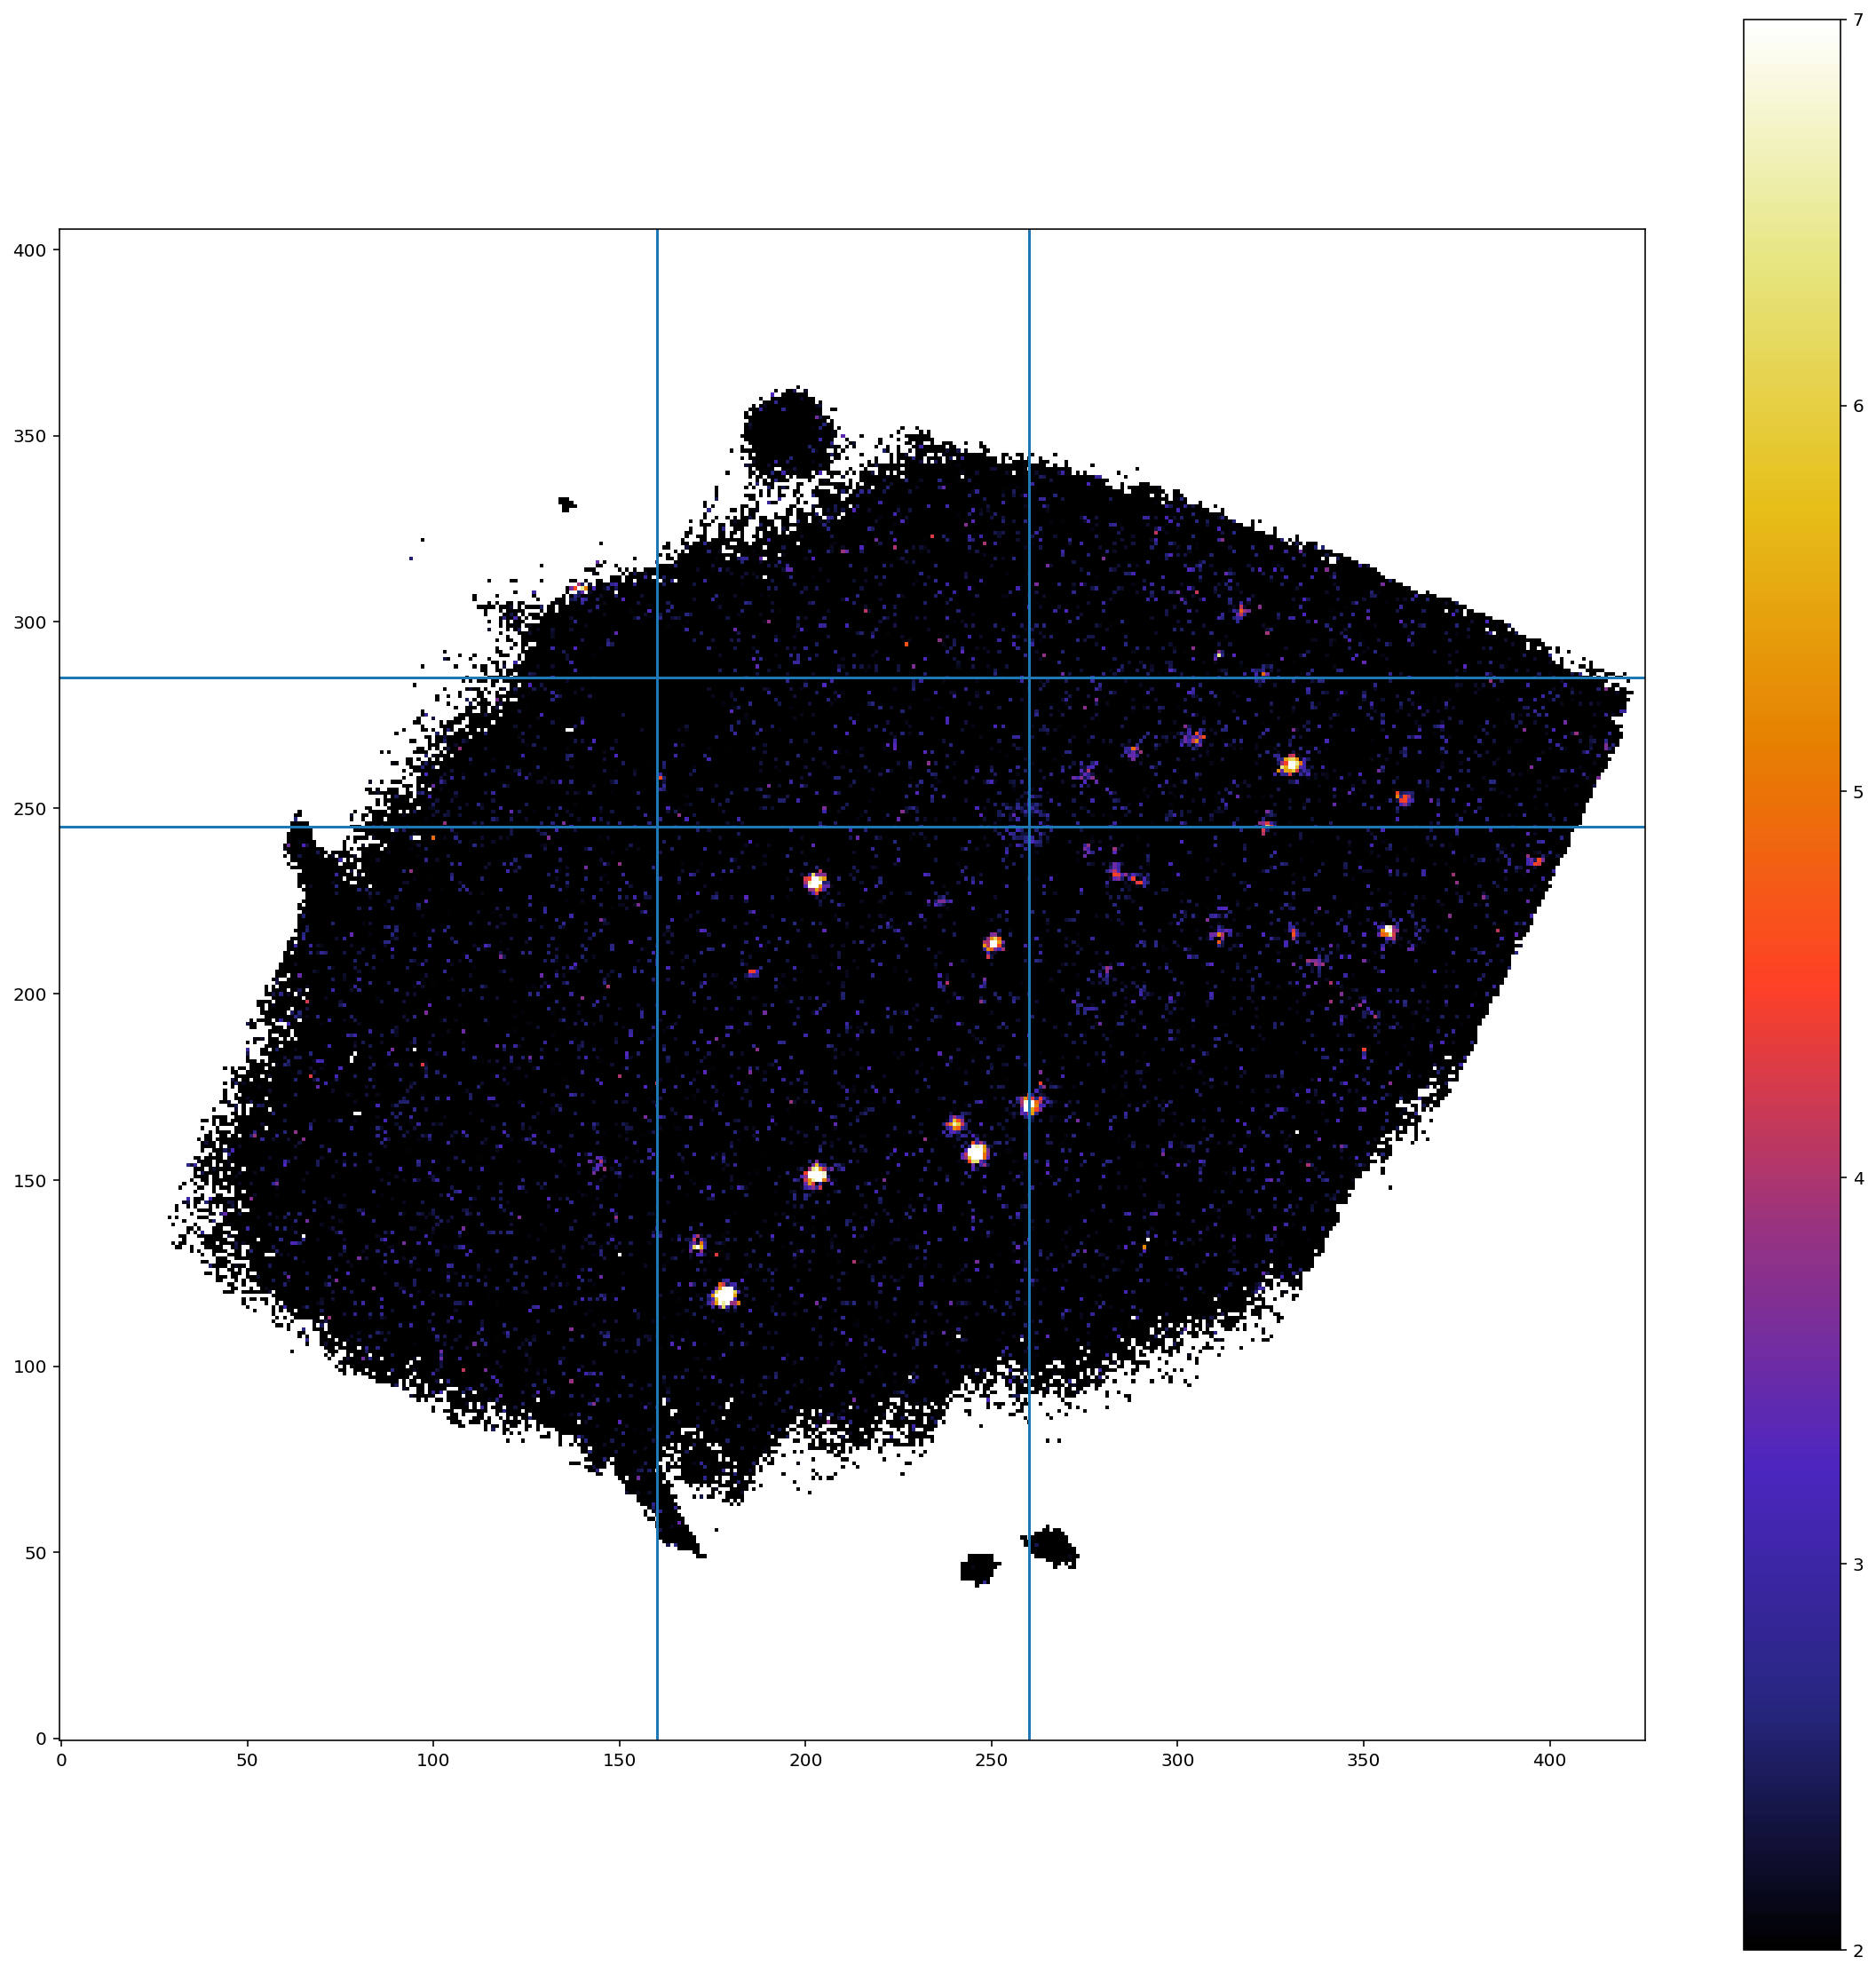

In [23]:
plt.figure(figsize=(20,20))
plt.imshow(A_rN_shape, origin="lower", cmap="CMRmap", vmin=2, vmax=7)
plt.colorbar()

plt.axhline(245)
plt.axvline(260)

plt.axhline(285)
plt.axvline(160)


# star fitting

In [41]:
def Gaussian_1D_res(params, x, data, error, spec_num):
    Amp = params["Amp"]
    mean = params["mean"]
    FWHM = params["FWHM"]
    Gauss_bkg = params["Gauss_bkg"]
    Gauss_grad = params["Gauss_grad"]

    Gauss_std = FWHM / 2.35482
    model = ((Gauss_bkg + Gauss_grad * x) + Amp * np.exp(- 0.5 * (x - mean)** 2 / Gauss_std**2.) +
             (Amp/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / Gauss_std**2.))

    list_of_rN[spec_num] = np.std(data - model)
    list_of_residuals[spec_num] = data - model

    return (data - model) / error

params = Parameters()
params.add("Amp",value=200., min=0.001)
params.add("mean", value=5060., vary=False)#, min=5000., max=5080.)
params.add("FWHM", value=2.81, vary=False) # LSF
params.add("Gauss_bkg", value=0.001,)# min=-500., max=500.)
params.add("Gauss_grad", value=0.00001)

n_pix = 25
star_0 = PNextractor(260, 245, n_pix, raw_data_list_stellar.reshape(y_data, x_data, len(wavelength)), wave=wavelength, dim=2 )
star_1 = PNextractor(160, 285, n_pix, raw_data_list_stellar.reshape(y_data, x_data, len(wavelength)), wave=wavelength, dim=2)

star_ = star_1
list_of_std_star = np.array([np.abs(np.std(spec)) for spec in star_])
input_errors_star = [np.repeat(list_of_std_star[i], len(wavelength)) for i in np.arange(0,len(list_of_std_star))]

list_of_rN = np.zeros(len(star_))
list_of_residuals = np.zeros((len(star_),len(wavelength)))
list_of_residuals_from_fitter = np.zeros((len(star_),len(wavelength)))
best_fit_A_star = np.zeros((len(star_),2))
best_fit_mean = np.zeros((len(star_),2))



In [42]:
for i ,spec_ in enumerate(star_):
    results = minimize(Gaussian_1D_res, params, args=(wavelength, spec_, input_errors_star[i], i), nan_policy="propagate")
    best_fit_A_star[i] = [results.params["Amp"], results.params["Amp"].stderr]
    best_fit_mean[i] = [results.params["mean"], results.params["mean"].stderr]
    list_of_residuals_from_fitter[i] = results.residual

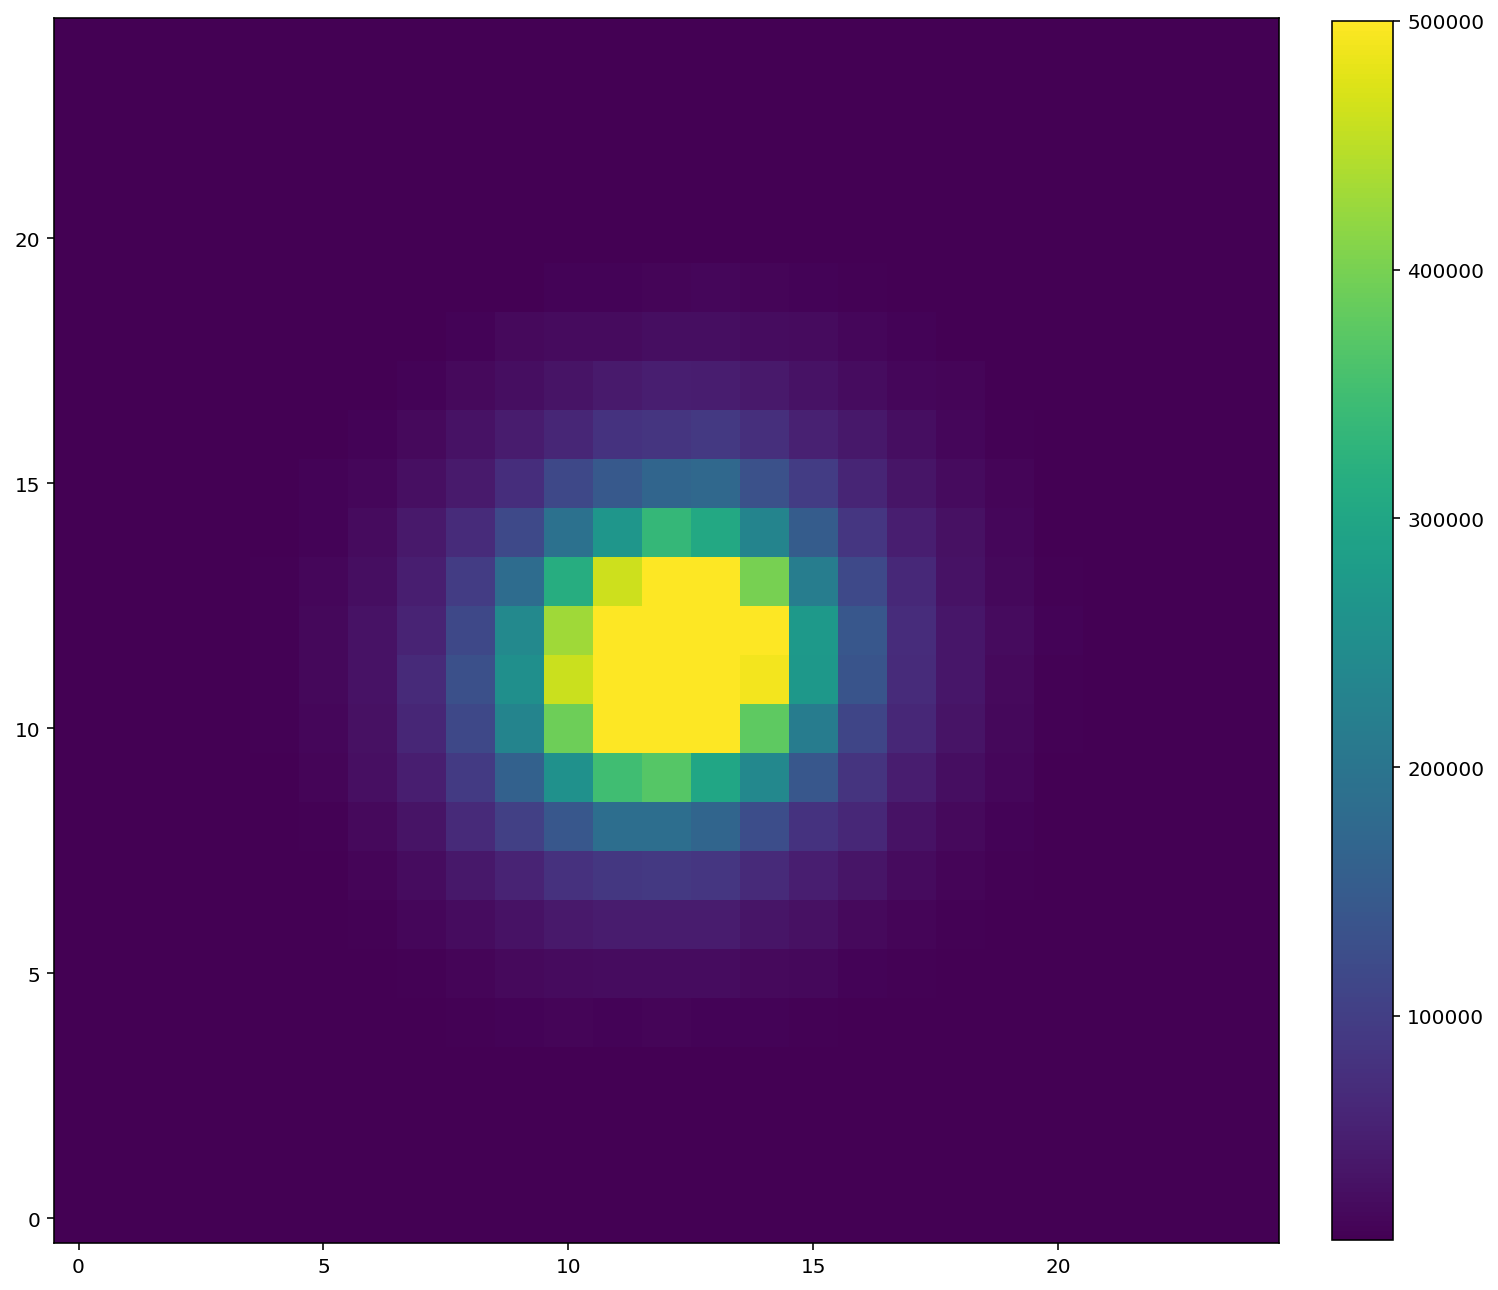

In [43]:
gauss_A_star = [A[0] for A in best_fit_A_star]
Gauss_F_star = np.sum(star_1,1)#np.array(gauss_A_star) * np.sqrt(2*np.pi) * 1.19
Gauss_F_star_shape = Gauss_F_star.reshape(n_pix,n_pix)

plt.figure(figsize=(12,12))
plt.imshow(Gauss_F_star_shape, origin="lower", vmin=1e4, vmax=5e5)
plt.colorbar(fraction=0.0455, pad=0.04)
plt.savefig("Plots/FCC277/Star_2D.png")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 153
    # data points      = 625
    # variables        = 6
    chi-square         = 1.6657e+10
    reduced chi-square = 26909068.3
    Akaike info crit   = 10698.4547
    Bayesian info crit = 10725.0812
[[Variables]]
    moff_amp:  882185.895 +/- 3070.85427 (0.35%) (init = 9000)
    x_0:       11.4000298 +/- 0.00510299 (0.04%) (init = 12.5)
    y_0:       12.0848531 +/- 0.00510303 (0.04%) (init = 12.5)
    FWHM:      4.29641767 +/- 0.01456311 (0.34%) (init = 6)
    beta:      2.73196308 +/- 0.05798945 (2.12%) (init = 2)
    bkg:       1851.40050 +/- 327.314814 (17.68%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(moff_amp, FWHM) = -0.844
    C(FWHM, beta)     =  0.727
    C(beta, bkg)      =  0.669
    C(moff_amp, beta) = -0.610
    C(moff_amp, bkg)  = -0.349
    C(FWHM, bkg)      =  0.272
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 48
    #

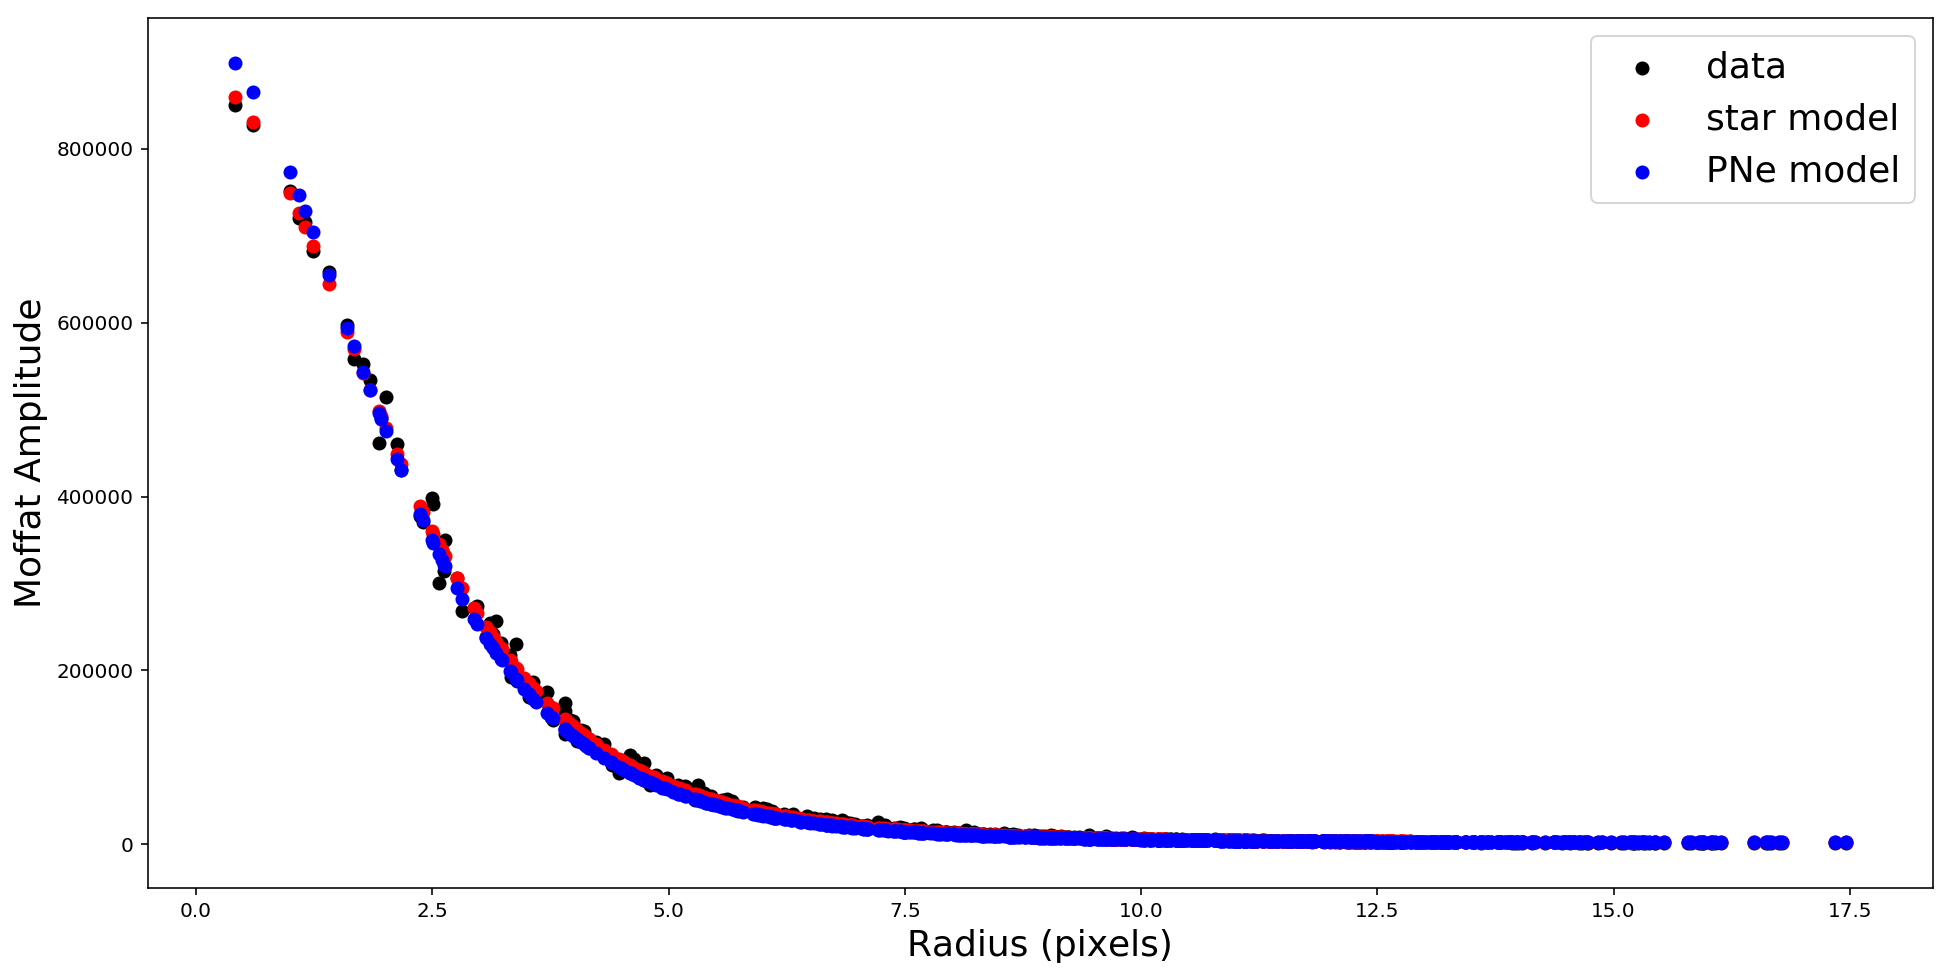

In [53]:
###### X_AOI, Y_AOI = np.mgrid[:n_pix,:n_pix]
star_ = Gauss_F_star
coordinates = [(n,m) for n in range(n_pix) for m in range(n_pix)]

x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

#list_of_residuals = np.zeros(len())
list_of_flux = []

def residuals(params, x_2D, y_2D, data):
    moff_amp = params["moff_amp"]
    x_0 = params["x_0"]
    y_0 = params["y_0"]
    FWHM = params["FWHM"]
    beta = params["beta"]
    bkg = params["bkg"]

    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((np.array(x_2D) - x_0)**2 + (np.array(y_2D) - y_0)**2) / gamma**2
    model = moff_amp * (1 + rr_gg)**(-beta) + bkg
    list_of_flux.clear()
    list_of_flux.append(model)
    #list_of_residuals[spec_num] = np.std(data - model)
    
    return data - model #/ np.std(flatten(data))

# Star initial parameters
S_params = Parameters()
S_params.add('moff_amp', value=9000., min=0.0001)
S_params.add('x_0', value=(n_pix/2), min=0001., max=n_pix)
S_params.add('y_0', value=(n_pix/2), min=0001., max=n_pix)
S_params.add('FWHM', value=6., min=0.001, max=30., vary=True)
S_params.add("beta", value=2., min=0.001, vary=True)
S_params.add("bkg", value=0.001, min=0.00001, vary=True)

#list_of_std = [np.abs(np.std(spec)) for spec in flat_raw_data]
#input_errors = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0,len(list_of_std))]

S_results = minimize(residuals, S_params, args=(x_fit, y_fit, star_), nan_policy="propagate")
print(report_fit(S_results))
star_model = list_of_flux

# PNe initial Parameters
P_params = Parameters()
P_params.add('moff_amp', value=9000., min=0.0001)
P_params.add('x_0', value=(n_pix/2), min=0001., max=n_pix)
P_params.add('y_0', value=(n_pix/2), min=0001., max=n_pix)
P_params.add('FWHM', value=4.09, min=0.001, max=12., vary=False)
P_params.add("beta", value=2.7, min=0.001, max=12., vary=False)
P_params.add("bkg", value=S_results.params["bkg"], min=0.00001, vary=False)
#S_results.params["bkg"].value]
#FWHM:  4.097199378103915 +/- 0.07372096340678978 (1.80%)
#Beta:  2.705787131855173 +/- 0.32699615666270926 (12.09%)


P_results = minimize(residuals, P_params, args=(x_fit, y_fit, star_), nan_policy="propagate")
print(report_fit(P_results))
PNe_model = list_of_flux

PNe_residuals = residuals(P_results.params, x_fit, y_fit, star_)
PNe_model = star_ - PNe_residuals

star_residuals = residuals(S_results.params, x_fit, y_fit, star_)
star_model = star_ - star_residuals

rad= np.sqrt((x_fit - S_results.params["x_0"])**2 + (y_fit - S_results.params["y_0"])**2)
plt.figure(figsize=(16,8))
plt.xlabel("Radius (pixels)", fontsize=18)
plt.ylabel("Moffat Amplitude", fontsize=18)
plt.scatter(rad, star_, color="k", label="data")
plt.scatter(rad, star_model, color="r", label="star model")
plt.scatter(rad, PNe_model, color="blue", label="PNe model")
plt.legend(prop={"size":18})
plt.savefig("Plots/FCC277/radial_star_profile_psf.png")

In [45]:
print("Star_: ", np.sum(star_)*1e-20)
print("Star: ", np.sum(star_model)*1e-20)
print("PNe:  ", np.sum(PNe_model)*1e-20)
print("Diff: ", ((np.abs(np.sum(star_model)-np.sum(PNe_model))))/np.sum(star_))

Star_:  2.641734795344122e-13
Star:  2.641734794678577e-13
PNe:   2.532608230168093e-13
Diff:  0.04130867515649648


24


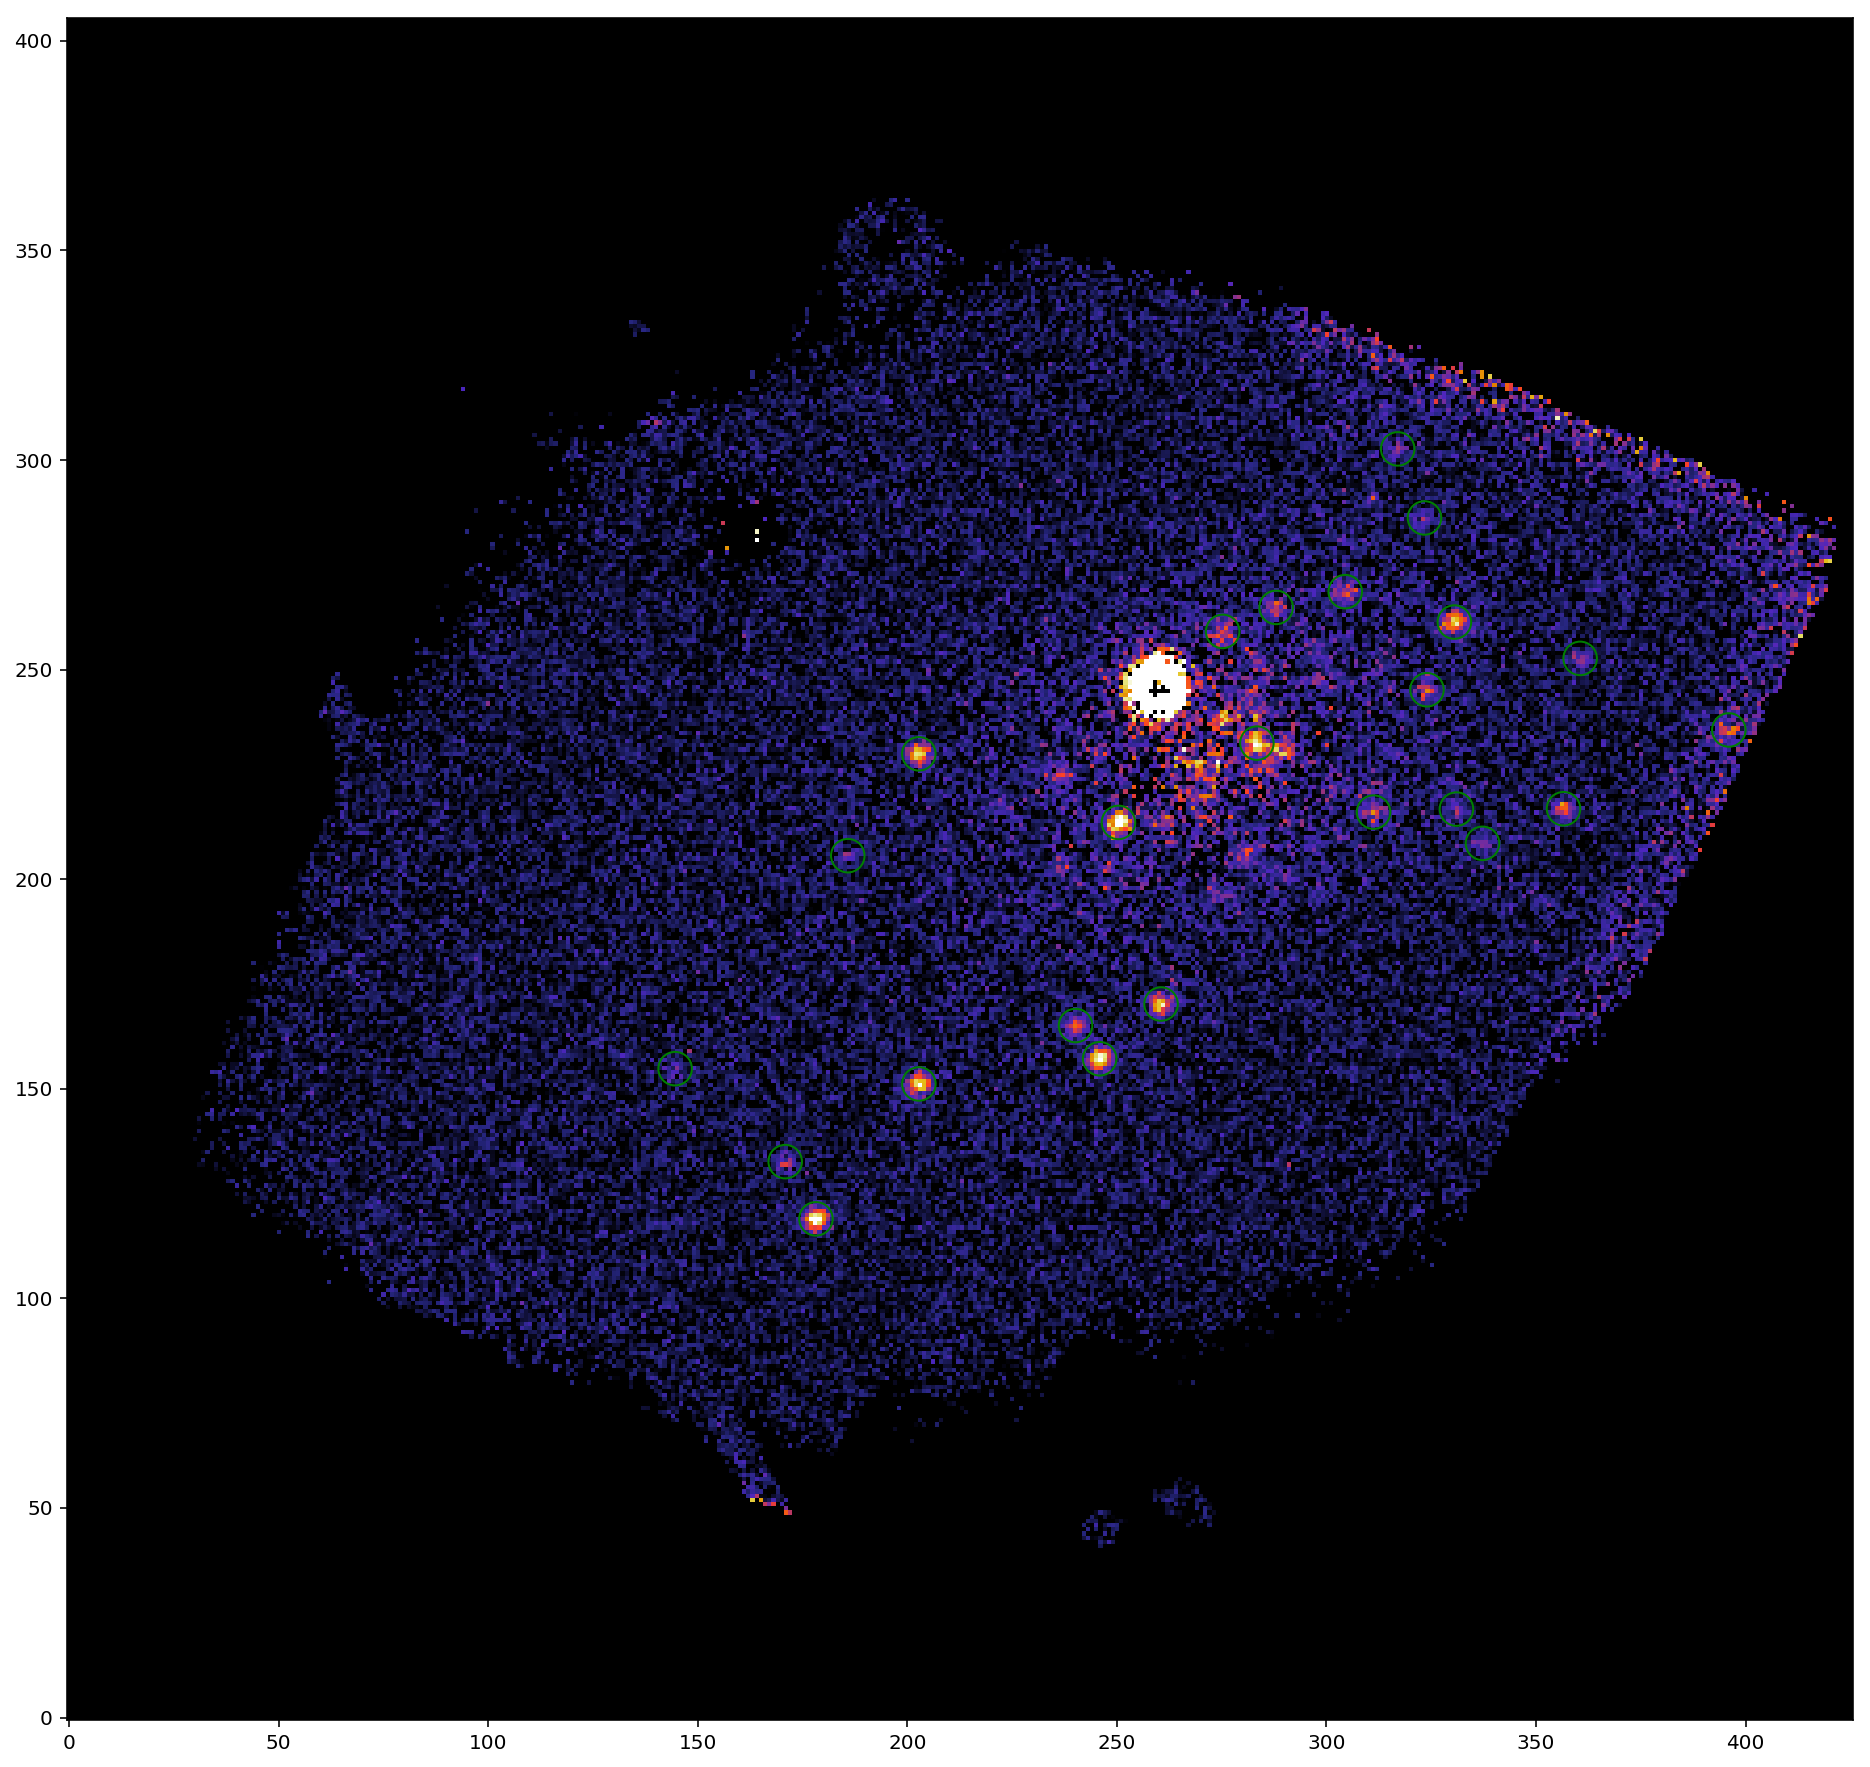

In [29]:
objects = sep.extract(A_rN_shape, 2.5, clean=True)
x_sep = objects["x"]
y_sep = objects["y"]

positions = (x_sep, y_sep)
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(Gauss_F_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=120.)
apertures.plot(color="green")


x_sep[12] = x_sep[12]-1
sep_x_y_list = [[x,y] for x,y in zip(x_sep, y_sep)]


print(len(x_sep))
np.save("exported_data/FCC277/sep_x_y_list", sep_x_y_list)